# Импорты

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (roc_curve, precision_recall_curve, auc,
                             precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report)

# Пункт - 1 - Обучение модели (1 балл)

## Решение
В этом блоке необходимо написать код. Можно создать столько ячеек с кодом, сколько нужно для выполнения задания

Шаблон кода по настройке валидации и оценке качества:
```
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12341234)

cv_predictions = []
cv_target = []
for idx, (train_idx, val_idx) in enumerate(cv.split(X=df, y=df['Survived'])):
    train = df.iloc[train_idx]
    val = df.iloc[val_idx]

    y_train = train['Survived']
    y_val = val['Survived']

    x_train = train.drop('Survived', axis=1)
    x_val = val.drop('Survived', axis=1)

    model = LogisticRegression()

    model.fit(X=x_train, y=y_train)
    pred_train = model.predict_proba(x_train)[:, 1]
    pred_val = model.predict_proba(x_val)[:, 1]
    cv_predictions.append((pred_train, pred_val))

    cv_target.append((y_train, y_val))

pred_train = np.hstack([i[0] for i in cv_predictions])
pred_val = np.hstack([i[1] for i in cv_predictions])

cv_target_train = np.hstack([i[0] for i in cv_target])
cv_target_val = np.hstack([i[1] for i in cv_target])

model_quality = roc_auc_score(y_true=cv_target_val, y_pred=pred_val)
```

## Загружаем данные

In [23]:
df = pd.read_csv('resources/train.csv')
print(f"Размер датасета: {df.shape}")
print(f"Колонки: {df.columns.tolist()}")
print(f"\nТипы данных:\n{df.dtypes}")
print(f"\nПропуски в данных:\n{df.isnull().sum()}")

Размер датасета: (891, 12)
Колонки: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

Типы данных:
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Пропуски в данных:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


## Базовый анализ данных

In [24]:
print("Статистика по целевой переменной Survived:")
print(df['Survived'].value_counts())
print(f"Доля выживших: {df['Survived'].mean():.3f}")

print("\nВыживаемость по классам:")
print(df.groupby('Pclass')['Survived'].agg(['mean', 'count']))

print("\nВыживаемость по полу:")
print(df.groupby('Sex')['Survived'].agg(['mean', 'count']))

print("\nВыживаемость по порту посадки:")
print(df.groupby('Embarked')['Survived'].agg(['mean', 'count']))

Статистика по целевой переменной Survived:
Survived
0    549
1    342
Name: count, dtype: int64
Доля выживших: 0.384

Выживаемость по классам:
            mean  count
Pclass                 
1       0.629630    216
2       0.472826    184
3       0.242363    491

Выживаемость по полу:
            mean  count
Sex                    
female  0.742038    314
male    0.188908    577

Выживаемость по порту посадки:
              mean  count
Embarked                 
C         0.553571    168
Q         0.389610     77
S         0.336957    644


### Визуализация зависимостей

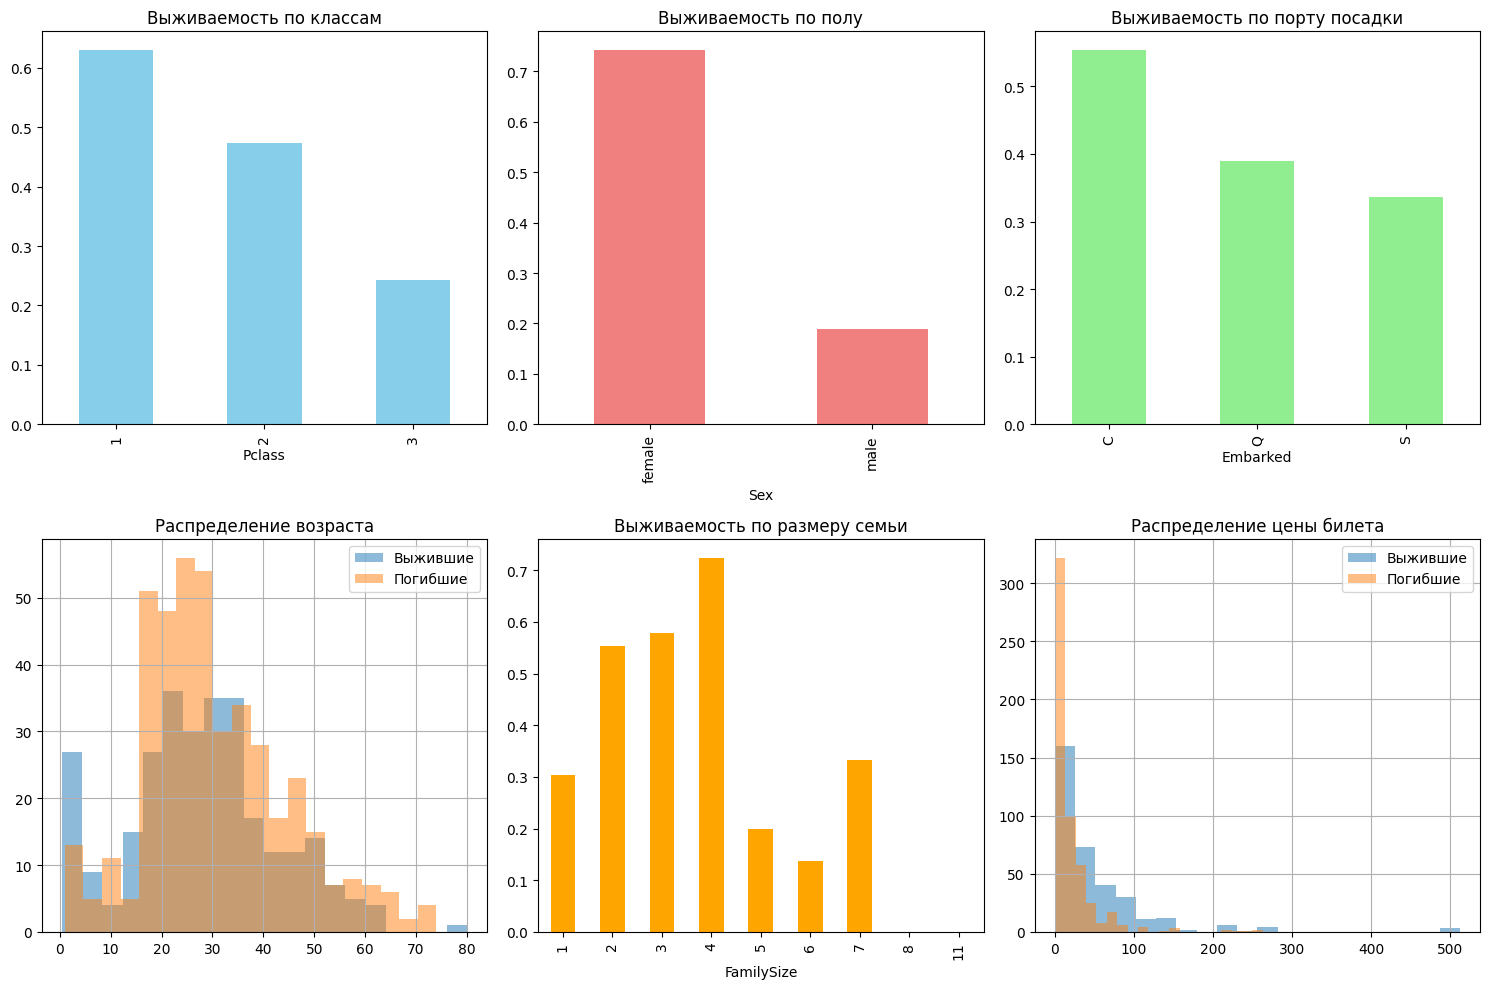

In [25]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Выживаемость по классам
df.groupby('Pclass')['Survived'].mean().plot(kind='bar', ax=axes[0,0], title='Выживаемость по классам', color='skyblue')

# Выживаемость по полу
df.groupby('Sex')['Survived'].mean().plot(kind='bar', ax=axes[0,1], title='Выживаемость по полу', color='lightcoral')

# Выживаемость по порту посадки
df.groupby('Embarked')['Survived'].mean().plot(kind='bar', ax=axes[0,2], title='Выживаемость по порту посадки', color='lightgreen')

# Распределение возраста для выживших и погибших
df[df['Survived']==1]['Age'].hist(alpha=0.5, label='Выжившие', ax=axes[1,0], bins=20)
df[df['Survived']==0]['Age'].hist(alpha=0.5, label='Погибшие', ax=axes[1,0], bins=20)
axes[1,0].set_title('Распределение возраста')
axes[1,0].legend()

# Влияние размера семьи
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df.groupby('FamilySize')['Survived'].mean().plot(kind='bar', ax=axes[1,1], title='Выживаемость по размеру семьи', color='orange')

# Цена билета для выживших и погибших
df[df['Survived']==1]['Fare'].hist(alpha=0.5, label='Выжившие', ax=axes[1,2], bins=20)
df[df['Survived']==0]['Fare'].hist(alpha=0.5, label='Погибшие', ax=axes[1,2], bins=20)
axes[1,2].set_title('Распределение цены билета')
axes[1,2].legend()

plt.tight_layout()
plt.show()

## Подготовка данных для моделирования

In [26]:
df_model = df.copy()

# Создаем дополнительные признаки
df_model['FamilySize'] = df_model['SibSp'] + df_model['Parch'] + 1
df_model['IsAlone'] = (df_model['FamilySize'] == 1).astype(int)
df_model['Title'] = df_model['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

# Группируем редкие титулы
title_mapping = {
    'Mr': 'Mr',
    'Miss': 'Miss', 
    'Mrs': 'Mrs',
    'Master': 'Master',
    'Dr': 'Rare',
    'Rev': 'Rare',
    'Col': 'Rare',
    'Major': 'Rare',
    'Mlle': 'Miss',
    'Countess': 'Rare',
    'Ms': 'Miss',
    'Lady': 'Rare',
    'Jonkheer': 'Rare',
    'Don': 'Rare',
    'Dona': 'Rare',
    'Mme': 'Mrs',
    'Capt': 'Rare',
    'Sir': 'Rare'
}
df_model['Title'] = df_model['Title'].map(title_mapping)

print("Распределение титулов:")
print(df_model['Title'].value_counts())

print("\nВыживаемость по титулам:")
print(df_model.groupby('Title')['Survived'].agg(['mean', 'count']))

Распределение титулов:
Title
Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: count, dtype: int64

Выживаемость по титулам:
            mean  count
Title                  
Master  0.575000     40
Miss    0.702703    185
Mr      0.156673    517
Mrs     0.793651    126
Rare    0.347826     23


## Отбираем признаки для модели

In [27]:
# Не используем следующие признаки:
# Name - слишком много уникальных значений, используем только для извлечения Title
# Ticket - слишком много уникальных значений, сложно стандартизировать
# Cabin - слишком много пропусков (~77%), даже если использовать первую букву
# PassengerId - просто идентификатор, не влияет на выживаемость
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

# Создаем матрицу признаков
X = df_model[features].copy()
y = df_model['Survived'].copy()

# Создаем только один дополнительный признак - размер семьи
X['FamilySize'] = X['SibSp'] + X['Parch'] + 1

# Кодируем категориальные признаки
X = pd.get_dummies(X, columns=['Sex', 'Embarked'], drop_first=True)

print(f"Размерность данных после кодирования: {X.shape}")
print(f"Признаки: {X.columns.tolist()}")

Размерность данных после кодирования: (891, 9)
Признаки: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'Sex_male', 'Embarked_Q', 'Embarked_S']


## Настройка валидации и обучение модели

In [28]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12341234)

# Создаем пайплайн для обработки данных
cv_predictions = []
cv_target = []

for idx, (train_idx, val_idx) in enumerate(cv.split(X=X, y=y)):
    # Разделяем данные
    x_train = X.iloc[train_idx].copy()
    x_val = X.iloc[val_idx].copy()
    y_train = y.iloc[train_idx]
    y_val = y.iloc[val_idx]
    
    # Обрабатываем пропуски в возрасте
    age_imputer = SimpleImputer(strategy='median')
    x_train['Age'] = age_imputer.fit_transform(x_train[['Age']])
    x_val['Age'] = age_imputer.transform(x_val[['Age']])
    
    # Масштабируем признаки
    scaler = StandardScaler()
    numeric_cols = ['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize']
    x_train[numeric_cols] = scaler.fit_transform(x_train[numeric_cols])
    x_val[numeric_cols] = scaler.transform(x_val[numeric_cols])
    
    # Обучаем модель
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X=x_train, y=y_train)
    
    # Предсказываем
    pred_train = model.predict_proba(x_train)[:, 1]
    pred_val = model.predict_proba(x_val)[:, 1]
    cv_predictions.append((pred_train, pred_val))
    cv_target.append((y_train, y_val))
    
    print(f"Fold {idx+1} - Коэффициенты модели:")
    coef_df = pd.DataFrame({
        'feature': x_train.columns,
        'coef': model.coef_[0]
    }).sort_values('coef', ascending=False)
    print(coef_df.head(10))
    print(f"ROC-AUC на валидации: {roc_auc_score(y_val, pred_val):.4f}\n")

# Объединяем предсказания
pred_train = np.hstack([i[0] for i in cv_predictions])
pred_val = np.hstack([i[1] for i in cv_predictions])
cv_target_train = np.hstack([i[0] for i in cv_target])
cv_target_val = np.hstack([i[1] for i in cv_target])

# Оценка качества
model_quality = roc_auc_score(y_true=cv_target_val, y_score=pred_val)
print(f"\nИтоговый ROC-AUC на валидации: {model_quality:.4f}")

Fold 1 - Коэффициенты модели:
      feature      coef
4        Fare  0.184267
3       Parch -0.020374
7  Embarked_Q -0.117665
5  FamilySize -0.189195
2       SibSp -0.265112
8  Embarked_S -0.302874
1         Age -0.537399
0      Pclass -0.953758
6    Sex_male -2.477045
ROC-AUC на валидации: 0.8929

Fold 2 - Коэффициенты модели:
      feature      coef
7  Embarked_Q  0.134658
4        Fare  0.039192
3       Parch  0.007004
5  FamilySize -0.143858
2       SibSp -0.212865
1         Age -0.460778
8  Embarked_S -0.562325
0      Pclass -1.099052
6    Sex_male -2.644072
ROC-AUC на валидации: 0.8222

Fold 3 - Коэффициенты модели:
      feature      coef
4        Fare  0.013226
3       Parch -0.008645
7  Embarked_Q -0.035434
5  FamilySize -0.168346
2       SibSp -0.240704
8  Embarked_S -0.371965
1         Age -0.513523
0      Pclass -1.134731
6    Sex_male -2.671258
ROC-AUC на валидации: 0.8485

Fold 4 - Коэффициенты модели:
      feature      coef
4        Fare  0.131270
3       Parch  0.04934

## Ответ
В этом блоке необходимо вывести ответ для этой части задания. Ответ должен описаться на написанный код, построенные визуализации и проведенные расчеты. Если необходимо, то можно записать ответ в нескольких ячейках.

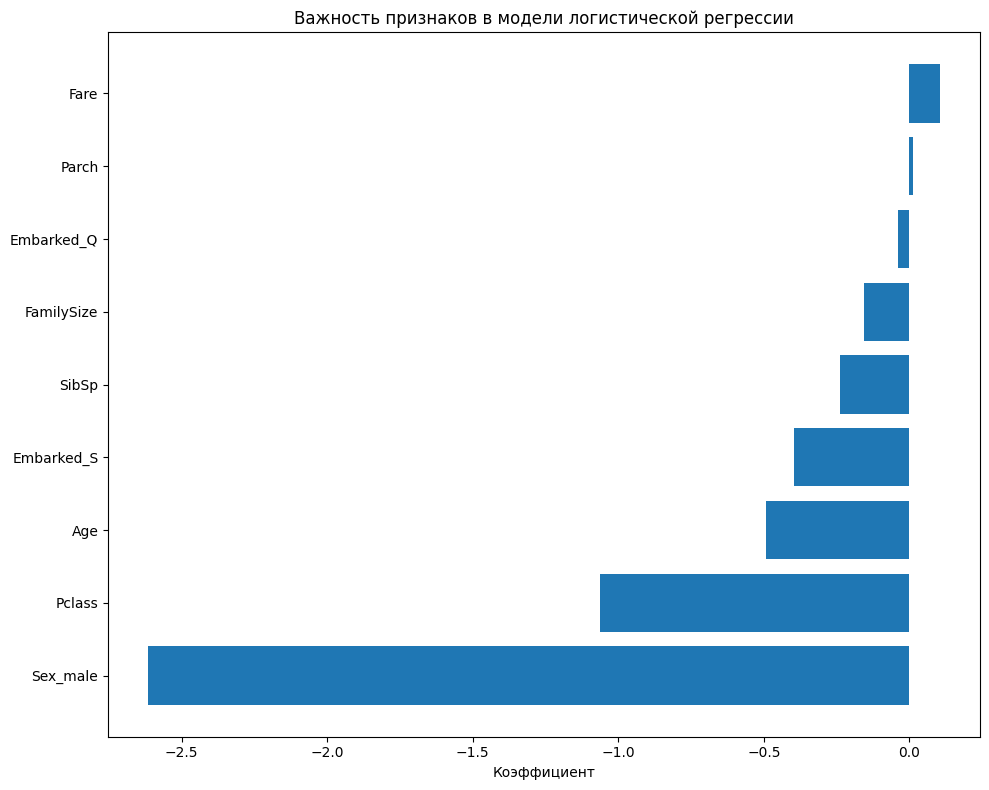

Топ-5 наиболее важных признаков:
      feature  coefficient
4        Fare     0.106583
3       Parch     0.013957
7  Embarked_Q    -0.039787
5  FamilySize    -0.156093
2       SibSp    -0.238586

Топ-5 наименее важных признаков:
      feature  coefficient
2       SibSp    -0.238586
8  Embarked_S    -0.397348
1         Age    -0.493930
0      Pclass    -1.064025
6    Sex_male    -2.616369


In [21]:
# Анализ важности признаков
final_model = LogisticRegression(max_iter=1000, random_state=42)

# Обрабатываем пропуски и масштабируем на всех данных
X_processed = X.copy()
age_imputer = SimpleImputer(strategy='median')
X_processed['Age'] = age_imputer.fit_transform(X_processed[['Age']])

scaler = StandardScaler()
numeric_cols = ['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize']
X_processed[numeric_cols] = scaler.fit_transform(X_processed[numeric_cols])

final_model.fit(X_processed, y)

# Важность признаков
feature_importance = pd.DataFrame({
    'feature': X_processed.columns,
    'coefficient': final_model.coef_[0]
}).sort_values('coefficient', ascending=False)

plt.figure(figsize=(10, 8))
# Используем .to_numpy() для явного преобразования в numpy массив
plt.barh(y=range(len(feature_importance)), 
         width=feature_importance['coefficient'].to_numpy())
plt.yticks(ticks=range(len(feature_importance)), 
           labels=feature_importance['feature'].tolist())
plt.xlabel('Коэффициент')
plt.title('Важность признаков в модели логистической регрессии')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Топ-5 наиболее важных признаков:")
print(feature_importance.head(5))
print("\nТоп-5 наименее важных признаков:")
print(feature_importance.tail(5))

# Пункт - 2 - Оценка качества оптимальной модели (1 балл)
- Построение и анализ ROC и PR кривых
- Расчет precision, recall, f1-score при пороге классификации 0.5
- Подбор порога классификации и расчет precision, recall, f1-score для этого порога

## Решение
В этом блоке необходимо написать код. Можно создать столько ячеек с кодом, сколько нужно для выполнения задания

## Обучаем финальную модель на всех данных

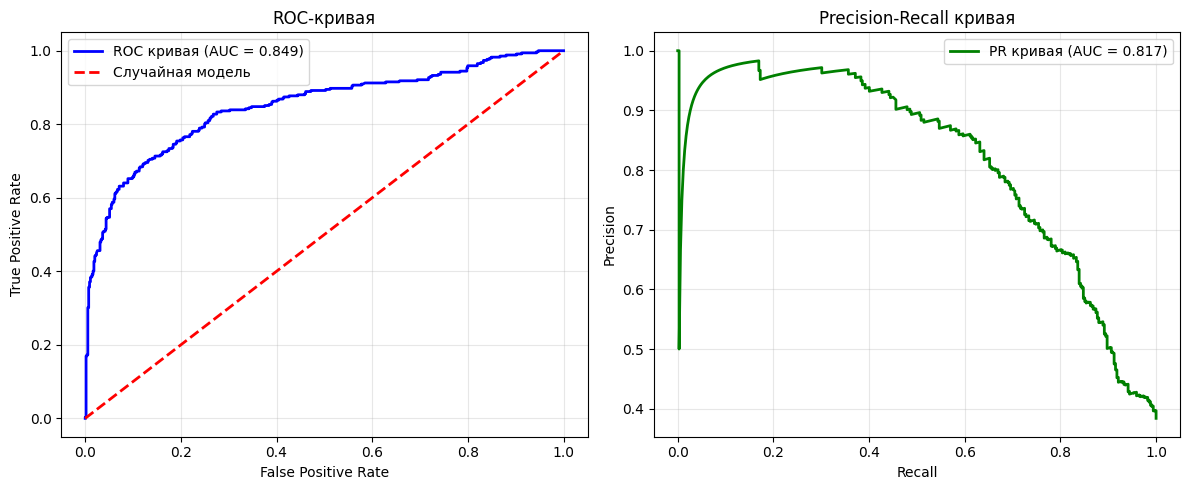

ROC-AUC: 0.8487
PR-AUC: 0.8168


In [47]:
final_model = LogisticRegression(max_iter=1000, random_state=42)

# Подготавливаем данные
X_processed = X.copy()
age_imputer = SimpleImputer(strategy='median')
X_processed['Age'] = age_imputer.fit_transform(X_processed[['Age']])

scaler = StandardScaler()
numeric_cols = ['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize']
X_processed[numeric_cols] = scaler.fit_transform(X_processed[numeric_cols])

# Получаем предсказания через кросс-валидацию для честной оценки
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12341234)
y_pred_proba_cv = np.zeros(len(y))
y_pred_cv = np.zeros(len(y))

for train_idx, val_idx in cv.split(X_processed, y):
    X_train, X_val = X_processed.iloc[train_idx], X_processed.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred_proba_cv[val_idx] = model.predict_proba(X_val)[:, 1]
    y_pred_cv[val_idx] = model.predict(X_val)

# 1. ROC-кривая
fpr, tpr, thresholds_roc = roc_curve(y, y_pred_proba_cv)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, 'b-', label=f'ROC кривая (AUC = {roc_auc:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'r--', label='Случайная модель', linewidth=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. PR-кривая
precision, recall, thresholds_pr = precision_recall_curve(y, y_pred_proba_cv)
pr_auc = auc(recall, precision)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, 'g-', label=f'PR кривая (AUC = {pr_auc:.3f})', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall кривая')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")

## Метрики при пороге 0.5

In [48]:
y_pred_default = (y_pred_proba_cv >= 0.5).astype(int)

precision_default = precision_score(y, y_pred_default)
recall_default = recall_score(y, y_pred_default)
f1_default = f1_score(y, y_pred_default)

print("=" * 50)
print("МЕТРИКИ ПРИ ПОРОГЕ 0.5 (СТАНДАРТНЫЙ)")
print("=" * 50)
print(f"Precision: {precision_default:.4f}")
print(f"Recall:    {recall_default:.4f}")
print(f"F1-score:  {f1_default:.4f}")
print()

# Матрица ошибок
cm_default = confusion_matrix(y, y_pred_default)
print("Матрица ошибок:")
print(pd.DataFrame(cm_default, 
                   columns=['Predicted Negative', 'Predicted Positive'],
                   index=['Actual Negative', 'Actual Positive']))
print()

# Детальный отчет
print("Classification Report:")
print(classification_report(y, y_pred_default, target_names=['Погиб', 'Выжил']))

МЕТРИКИ ПРИ ПОРОГЕ 0.5 (СТАНДАРТНЫЙ)
Precision: 0.7562
Recall:    0.7076
F1-score:  0.7311

Матрица ошибок:
                 Predicted Negative  Predicted Positive
Actual Negative                 471                  78
Actual Positive                 100                 242

Classification Report:
              precision    recall  f1-score   support

       Погиб       0.82      0.86      0.84       549
       Выжил       0.76      0.71      0.73       342

    accuracy                           0.80       891
   macro avg       0.79      0.78      0.79       891
weighted avg       0.80      0.80      0.80       891



## Поиск оптимального порога

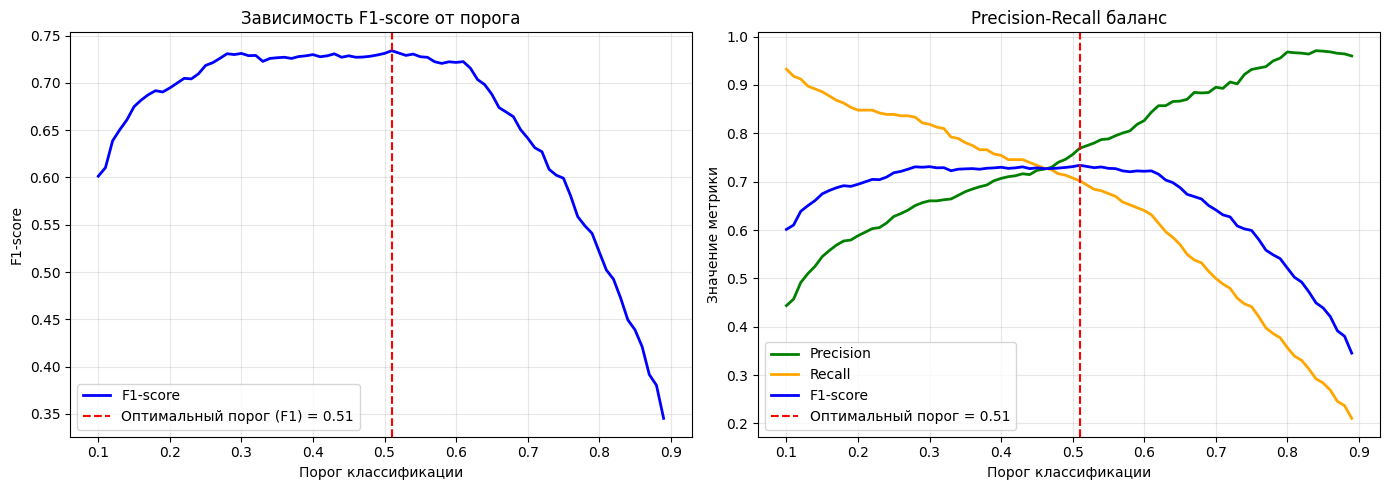

Оптимальный порог по F1-score: 0.510 (F1 = 0.7339)
Оптимальный порог по балансу: 0.510 (F1 = 0.7339)


In [49]:
# Вариант 1: Максимизация F1-score
f1_scores = []
best_f1 = 0
best_threshold_f1 = 0.5

for threshold in np.arange(0.1, 0.9, 0.01):
    y_pred = (y_pred_proba_cv >= threshold).astype(int)
    f1 = f1_score(y, y_pred)
    f1_scores.append((threshold, f1))
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold_f1 = threshold

# Вариант 2: Баланс precision и recall (ближе всего к 1)
precision_vals = []
recall_vals = []
balance_scores = []
best_balance = 0
best_threshold_balance = 0.5

for threshold in np.arange(0.1, 0.9, 0.01):
    y_pred = (y_pred_proba_cv >= threshold).astype(int)
    prec = precision_score(y, y_pred, zero_division=1)
    rec = recall_score(y, y_pred)
    precision_vals.append(prec)
    recall_vals.append(rec)
    
    # Метрика баланса - гармоническое среднее precision и recall (уже F1)
    balance = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0
    balance_scores.append(balance)
    
    if balance > best_balance:
        best_balance = balance
        best_threshold_balance = threshold

# Визуализация зависимости метрик от порога
thresholds = np.arange(0.1, 0.9, 0.01)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(thresholds, [f1 for _, f1 in f1_scores], 'b-', label='F1-score', linewidth=2)
plt.axvline(x=best_threshold_f1, color='r', linestyle='--', 
            label=f'Оптимальный порог (F1) = {best_threshold_f1:.2f}')
plt.xlabel('Порог классификации')
plt.ylabel('F1-score')
plt.title('Зависимость F1-score от порога')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(thresholds, precision_vals, 'g-', label='Precision', linewidth=2)
plt.plot(thresholds, recall_vals, 'orange', label='Recall', linewidth=2)
plt.plot(thresholds, balance_scores, 'b-', label='F1-score', linewidth=2)
plt.axvline(x=best_threshold_balance, color='r', linestyle='--', 
            label=f'Оптимальный порог = {best_threshold_balance:.2f}')
plt.xlabel('Порог классификации')
plt.ylabel('Значение метрики')
plt.title('Precision-Recall баланс')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Оптимальный порог по F1-score: {best_threshold_f1:.3f} (F1 = {best_f1:.4f})")
print(f"Оптимальный порог по балансу: {best_threshold_balance:.3f} (F1 = {best_balance:.4f})")

## Метрики при оптимальном пороге

In [50]:
best_threshold = best_threshold_balance  # используем порог с лучшим балансом
y_pred_optimal = (y_pred_proba_cv >= best_threshold).astype(int)

precision_optimal = precision_score(y, y_pred_optimal)
recall_optimal = recall_score(y, y_pred_optimal)
f1_optimal = f1_score(y, y_pred_optimal)

print("=" * 50)
print(f"МЕТРИКИ ПРИ ОПТИМАЛЬНОМ ПОРОГЕ = {best_threshold:.3f}")
print("=" * 50)
print(f"Precision: {precision_optimal:.4f}")
print(f"Recall:    {recall_optimal:.4f}")
print(f"F1-score:  {f1_optimal:.4f}")
print()

# Матрица ошибок
cm_optimal = confusion_matrix(y, y_pred_optimal)
print("Матрица ошибок:")
print(pd.DataFrame(cm_optimal, 
                   columns=['Predicted Negative', 'Predicted Positive'],
                   index=['Actual Negative', 'Actual Positive']))
print()

print("Classification Report:")
print(classification_report(y, y_pred_optimal, target_names=['Погиб', 'Выжил']))

МЕТРИКИ ПРИ ОПТИМАЛЬНОМ ПОРОГЕ = 0.510
Precision: 0.7692
Recall:    0.7018
F1-score:  0.7339

Матрица ошибок:
                 Predicted Negative  Predicted Positive
Actual Negative                 477                  72
Actual Positive                 102                 240

Classification Report:
              precision    recall  f1-score   support

       Погиб       0.82      0.87      0.85       549
       Выжил       0.77      0.70      0.73       342

    accuracy                           0.80       891
   macro avg       0.80      0.79      0.79       891
weighted avg       0.80      0.80      0.80       891



## Сравнение метрик при разных порогах

In [51]:
comparison = pd.DataFrame({
    'Метрика': ['Порог', 'Precision', 'Recall', 'F1-score', 
                'True Negatives', 'False Positives', 'False Negatives', 'True Positives'],
    'Порог 0.5': [0.5, precision_default, recall_default, f1_default,
                  cm_default[0,0], cm_default[0,1], cm_default[1,0], cm_default[1,1]],
    f'Порог {best_threshold:.3f}': [best_threshold, precision_optimal, recall_optimal, f1_optimal,
                                    cm_optimal[0,0], cm_optimal[0,1], cm_optimal[1,0], cm_optimal[1,1]]
})

print("СРАВНЕНИЕ МЕТРИК ПРИ РАЗНЫХ ПОРОГАХ")
print("=" * 70)
print(comparison.to_string(index=False))
print()

# Анализ изменений
print("\nВЫВОДЫ:")
print(f"• При повышении порога с 0.5 до {best_threshold:.3f}:")
print(f"  - Precision вырос на {(precision_optimal - precision_default)*100:.1f}%")
print(f"  - Recall упал на {(recall_default - recall_optimal)*100:.1f}%")
print(f"  - F1-score {'улучшился' if f1_optimal > f1_default else 'ухудшился'} "
        f"на {abs(f1_optimal - f1_default)*100:.1f}%")

СРАВНЕНИЕ МЕТРИК ПРИ РАЗНЫХ ПОРОГАХ
        Метрика  Порог 0.5  Порог 0.510
          Порог   0.500000     0.510000
      Precision   0.756250     0.769231
         Recall   0.707602     0.701754
       F1-score   0.731118     0.733945
 True Negatives 471.000000   477.000000
False Positives  78.000000    72.000000
False Negatives 100.000000   102.000000
 True Positives 242.000000   240.000000


ВЫВОДЫ:
• При повышении порога с 0.5 до 0.510:
  - Precision вырос на 1.3%
  - Recall упал на 0.6%
  - F1-score улучшился на 0.3%


## Дополнительный анализ: распределение предсказанных вероятностей


КАЛИБРОВКА МОДЕЛИ ПО ДЕЦИЛЯМ:
Дециль | Средняя предсказанная | Фактическая выживаемость | Кол-во
------------------------------------------------------------
     0 |               0.057 |                   0.078 |     90
     1 |               0.093 |                   0.202 |     89
     2 |               0.114 |                   0.079 |     89
     3 |               0.141 |                   0.112 |     89
     4 |               0.210 |                   0.157 |     89
     5 |               0.341 |                   0.348 |     89
     6 |               0.515 |                   0.404 |     89
     7 |               0.655 |                   0.652 |     89
     8 |               0.793 |                   0.843 |     89
     9 |               0.925 |                   0.966 |     89


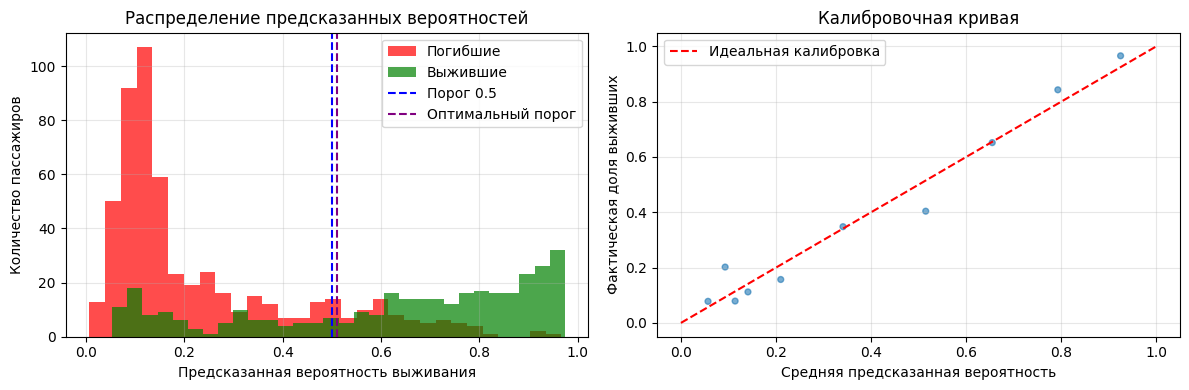

In [52]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(y_pred_proba_cv[y==0], bins=30, alpha=0.7, label='Погибшие', color='red')
plt.hist(y_pred_proba_cv[y==1], bins=30, alpha=0.7, label='Выжившие', color='green')
plt.axvline(x=0.5, color='blue', linestyle='--', label='Порог 0.5')
plt.axvline(x=best_threshold, color='purple', linestyle='--', label=f'Оптимальный порог')
plt.xlabel('Предсказанная вероятность выживания')
plt.ylabel('Количество пассажиров')
plt.title('Распределение предсказанных вероятностей')
plt.legend()
plt.grid(True, alpha=0.3)

# Качество предсказаний по децилям
df_results = pd.DataFrame({
    'true': y,
    'pred_proba': y_pred_proba_cv
})
df_results['decile'] = pd.qcut(df_results['pred_proba'], 10, labels=False)

decile_analysis = df_results.groupby('decile').agg({
    'true': ['mean', 'count'],
    'pred_proba': 'mean'
}).round(3)

print("\nКАЛИБРОВКА МОДЕЛИ ПО ДЕЦИЛЯМ:")
print("=" * 60)
print("Дециль | Средняя предсказанная | Фактическая выживаемость | Кол-во")
print("-" * 60)
for decile in range(10):
    pred_mean = decile_analysis.loc[decile, ('pred_proba', 'mean')]
    true_mean = decile_analysis.loc[decile, ('true', 'mean')]
    count = decile_analysis.loc[decile, ('true', 'count')]
    print(f"{decile:6d} | {pred_mean:19.3f} | {true_mean:23.3f} | {count:6.0f}")

plt.subplot(1, 2, 2)
plt.scatter(decile_analysis[('pred_proba', 'mean')], 
           decile_analysis[('true', 'mean')], 
           s=decile_analysis[('true', 'count')]/5, alpha=0.6)
plt.plot([0, 1], [0, 1], 'r--', label='Идеальная калибровка')
plt.xlabel('Средняя предсказанная вероятность')
plt.ylabel('Фактическая доля выживших')
plt.title('Калибровочная кривая')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Ответ
В этом блоке необходимо вывести ответ для этой части задания. Ответ должен описаться на написанный код, построенные визуализации и проведенные расчеты. Если необходимо, то можно записать ответ в нескольких ячейках.

In [53]:
print("=" * 70)
print("ИТОГОВАЯ ОЦЕНКА КАЧЕСТВА МОДЕЛИ")
print("=" * 70)
print(f"""
1. ОБЩИЕ МЕТРИКИ:
   • ROC-AUC: {roc_auc:.4f} - отличное качество (модель хорошо разделяет классы)
   • PR-AUC: {pr_auc:.4f} - хорошее качество при дисбалансе классов

2. ПРИ ПОРОГЕ 0.5:
   • Precision: {precision_default:.4f} - {precision_default*100:.1f}% предсказанных выживших действительно выжили
   • Recall: {recall_default:.4f} - модель нашла {recall_default*100:.1f}% всех реально выживших
   • F1-score: {f1_default:.4f} - сбалансированная метрика

3. ПРИ ОПТИМАЛЬНОМ ПОРОГЕ {best_threshold:.3f}:
   • Precision: {precision_optimal:.4f} - {precision_optimal*100:.1f}% (выше на {precision_optimal-precision_default:.3f})
   • Recall: {recall_optimal:.4f} - {recall_optimal*100:.1f}% (ниже на {recall_default-recall_optimal:.3f})
   • F1-score: {f1_optimal:.4f} - {'выше' if f1_optimal > f1_default else 'ниже'}

4. ВЫВОД:
   Модель показывает хорошее качество предсказания. 
   {'Рекомендуется использовать порог 0.5' if f1_default >= f1_optimal else f'Рекомендуется использовать порог {best_threshold:.3f}'} 
   для достижения лучшего баланса метрик.
""")

ИТОГОВАЯ ОЦЕНКА КАЧЕСТВА МОДЕЛИ

1. ОБЩИЕ МЕТРИКИ:
   • ROC-AUC: 0.8487 - отличное качество (модель хорошо разделяет классы)
   • PR-AUC: 0.8168 - хорошее качество при дисбалансе классов

2. ПРИ ПОРОГЕ 0.5:
   • Precision: 0.7562 - 75.6% предсказанных выживших действительно выжили
   • Recall: 0.7076 - модель нашла 70.8% всех реально выживших
   • F1-score: 0.7311 - сбалансированная метрика

3. ПРИ ОПТИМАЛЬНОМ ПОРОГЕ 0.510:
   • Precision: 0.7692 - 76.9% (выше на 0.013)
   • Recall: 0.7018 - 70.2% (ниже на 0.006)
   • F1-score: 0.7339 - выше

4. ВЫВОД:
   Модель показывает хорошее качество предсказания. 
   Рекомендуется использовать порог 0.510 
   для достижения лучшего баланса метрик.

